# MNIST Project

In this blog, we will use neural networks to train MNIST dataset. We start with using pytorch and integrate fastai in the end.

This is part of Further Research from fastbook [chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

## Preparing data

This part is the same as last blog where we created a baseline by calculating means of images.

In [ ]:
from fastai.vision.all import *

In [ ]:
matplotlib.rc('image', cmap='Greys')
torch.manual_seed(42)

<torch._C.Generator>

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
(path/'training').ls()

(#10) [Path('training/7'),Path('training/8'),Path('training/5'),Path('training/6'),Path('training/9'),Path('training/3'),Path('training/2'),Path('training/0'),Path('training/4'),Path('training/1')]

I looked at the number of files for each number, and they are not the same.

In [ ]:
trn_counts = {n: len((path/'training'/str(n)).ls()) for n in range(10)}
trn_counts

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

Since these are paths for images we have to convert them into pytorch tensors. Pytorch provides us with [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) ability, which is very fast.

First, we turn image paths into numbers and return as L, which is an upgraded version of list. 

In [ ]:
def create_images(path):
    return L(PILImage.create(x) for x in path.ls())

In [ ]:
ones = create_images(path/'training'/'1')
im1 = ones[0]
im1

We need to turn them into tensors for speed. However, we have to check the shape of tensors to make sure they are broadcastable and the shape is one we're expecting.

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs])

In [ ]:
stacked_ones = create_tensor_imgs(ones)
stacked_ones[0].shape

torch.Size([28, 28, 3])

In [ ]:
stacked_ones.shape

torch.Size([6742, 28, 28, 3])

Looking at the shape of an image, it is interesting to find out that its shape is [28, 28, 3] (y, x, and color values). I was expecting to see [28, 28] (y and x values) because it is a black and white image. So, let's see what's going on here.

In [ ]:
array(im1)[10:15, 12:15]

array([[[  0,   0,   0],
        [221, 221, 221],
        [251, 251, 251]],

       [[ 64,  64,  64],
        [236, 236, 236],
        [251, 251, 251]],

       [[127, 127, 127],
        [251, 251, 251],
        [251, 251, 251]],

       [[127, 127, 127],
        [251, 251, 251],
        [251, 251, 251]],

       [[128, 128, 128],
        [253, 253, 253],
        [253, 253, 253]]], dtype=uint8)

So, it is just filled with the same numbers per each row. We just need one column, so we can simply take a mean of last rank.

In [ ]:
array(im1)[10:15, 12:15].mean(-1)

array([[  0., 221., 251.],
       [ 64., 236., 251.],
       [127., 251., 251.],
       [127., 251., 251.],
       [128., 253., 253.]])

So, here is the updated version of `create_tensor_imgs` that calculates a mean so that we can get rid of the last rank of our tensors. 

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs]).mean(-1, dtype=torch.float)

In [ ]:
stacked_ones = create_tensor_imgs(ones)
stacked_ones[0].shape

torch.Size([28, 28])

In [ ]:
array(stacked_ones[0])[10:15, 12:15]

array([[  0., 221., 251.],
       [ 64., 236., 251.],
       [127., 251., 251.],
       [127., 251., 251.],
       [128., 253., 253.]], dtype=float32)

Looks good. Now, we want those pixel values to be between 0 and 1 so that it is easier to train neural networks. 

In [ ]:
def create_tensor_imgs(imgs):
    "Convert a list of images into a tensor"
    return torch.stack([tensor(im) for im in imgs]).mean(-1, dtype=torch.float)/255

In [ ]:
stacked_ones = create_tensor_imgs(ones)
array(stacked_ones[0])[10:15, 12:15]

array([[0.        , 0.8666667 , 0.9843137 ],
       [0.2509804 , 0.9254902 , 0.9843137 ],
       [0.49803922, 0.9843137 , 0.9843137 ],
       [0.49803922, 0.9843137 , 0.9843137 ],
       [0.5019608 , 0.99215686, 0.99215686]], dtype=float32)

In [ ]:
def stacked_nums(path):
    "Converts path into stacked tensors."
    imgs = create_images(path)
    return create_tensor_imgs(imgs)

In [ ]:
stacked_zeros = stacked_nums(path/'training'/'0')
stacked_twos = stacked_nums(path/'training'/'2')
stacked_threes = stacked_nums(path/'training'/'3')
stacked_fours = stacked_nums(path/'training'/'4')
stacked_fives = stacked_nums(path/'training'/'5')
stacked_sixs = stacked_nums(path/'training'/'6')
stacked_sevens = stacked_nums(path/'training'/'7')
stacked_eights = stacked_nums(path/'training'/'8')
stacked_nines = stacked_nums(path/'training'/'9')

We also need test data to check how we're doing. Without test set, we don't know whether we are overfitting or not. So, we do the same process we did for test data.

In [ ]:
tst_0_tens = stacked_nums(path/'testing'/'0')
tst_1_tens = stacked_nums(path/'testing'/'1')
tst_2_tens = stacked_nums(path/'testing'/'2')
tst_3_tens = stacked_nums(path/'testing'/'3')
tst_4_tens = stacked_nums(path/'testing'/'4')
tst_5_tens = stacked_nums(path/'testing'/'5')
tst_6_tens = stacked_nums(path/'testing'/'6')
tst_7_tens = stacked_nums(path/'testing'/'7')
tst_8_tens = stacked_nums(path/'testing'/'8')
tst_9_tens = stacked_nums(path/'testing'/'9')

tst_tens = L([tst_0_tens, tst_1_tens, tst_2_tens, tst_3_tens, tst_4_tens, 
              tst_5_tens, tst_6_tens, tst_7_tens, tst_8_tens, tst_9_tens])

tst_counts = {n: len((path/'testing'/str(n)).ls()) for n in range(10)}

tst_1_tens.shape, tst_9_tens.shape

(torch.Size([1135, 28, 28]), torch.Size([1009, 28, 28]))

In [ ]:
tst_counts

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

Now, we stack all the training tensors together to create `trn_x`. And create `trn_y` with the counts. We zip those together to create a dataset. We also change the shape of tensors from [28, 28] to [784]. This shape is more useful for matrix multiplication we will do later.

In [ ]:
trn_x = torch.cat([stacked_zeros, stacked_ones, stacked_twos, 
                   stacked_threes, stacked_fours, stacked_fives, 
                   stacked_sixs, stacked_sevens, stacked_eights, 
                   stacked_nines]).view(-1, 28*28)

trn_y = tensor(list(flatten([[x] * y for x, y in trn_counts.items()])))
trn_dset = list(zip(trn_x, trn_y))

trn_x.shape, trn_y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

(<AxesSubplot:>, tensor(8))

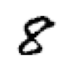

In [ ]:
show_image(trn_x[50000].view(28,28)), trn_y[50000]

In [ ]:
x, y = trn_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([]))

Training data looks good, so let's work on the test data.

In [ ]:
tst_x = torch.cat([tst_0_tens, tst_1_tens, tst_2_tens, 
                     tst_3_tens, tst_4_tens, tst_5_tens,
                     tst_6_tens, tst_7_tens, tst_8_tens,
                     tst_9_tens]).view(-1, 28*28)

tst_y = tensor(list(flatten([[x] * y for x, y in tst_counts.items()])))
tst_dset = list(zip(tst_x, tst_y))

tst_x.shape, tst_y.shape

(torch.Size([10000, 784]), torch.Size([10000]))

## Using neural network

In order to use neural network, we need to initialize parameters, such as weights and bias.

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(1)

We are initializing `weights` parameter with size (28\*28, 10) because `28*28` is the size of our input (reshaped images) and `10` is the size of our output. Why do we return 10 numbers as an output for each image? Because we're making predictions on each category (from 0 to 9). Out of all those 10 numbers, the biggest number is the model's guess. 

But couldn't we just output 1 number instead and pick a target based on the range of our output? For instance, we could use sigmoid function to get our output numbers to be between 0 and 1, and if it's between 0 and 0.1, it is 0, if it's between 0.1 and 0.2, it is 1, and so on. That's also a possible approach to this problem. 

With those parameters, we will perform matrix multiplications. There are multiple ways to calculate it. One way involves manually transposing a matrix and getting the sum over dimension 1, and another way involves using `@` operator, which does all of that for us. 

In [ ]:
(x*weights.T).sum(dim=1) + bias

tensor([-3.0786,  6.5823, 12.8080, 10.5792, -8.4876, 12.2374,  7.8472, -2.3099,
         2.4677, 16.0547], grad_fn=<AddBackward0>)

In [ ]:
x@weights + bias

tensor([-3.0786,  6.5823, 12.8080, 10.5792, -8.4876, 12.2374,  7.8472, -2.3099,
         2.4677, 16.0547], grad_fn=<AddBackward0>)

In [ ]:
def linear(xb): return xb@weights + bias

In [ ]:
preds = linear(trn_x)
preds

tensor([[ -3.0786,   6.5823,  12.8080,  ...,  -2.3099,   2.4677,  16.0547],
        [ -4.0905,   1.3646,  -1.6264,  ...,  -5.0465,  -8.9219,   5.3742],
        [ -4.6858,  -1.6842,   5.6141,  ...,  -7.0370,   7.6748,   1.3543],
        ...,
        [-15.4864,  -1.8742,  -6.2627,  ...,  -0.1359,  10.1261,  18.8826],
        [-22.5967,   5.1747,  -6.5157,  ...,  -2.5263,  20.9854,  12.2597],
        [-15.9537,  -2.7749,   3.1555,  ...,   5.3508,  11.7086,  13.8179]],
       grad_fn=<AddBackward0>)

So, we know that these numbers represent "socres" for each category. Let's look at the first prediction.

In [ ]:
preds[0]

tensor([-3.0786,  6.5823, 12.8080, 10.5792, -8.4876, 12.2374,  7.8472, -2.3099,
         2.4677, 16.0547], grad_fn=<SelectBackward0>)

From these numbers, the biggest number is 16.0547, which is a prediction for 9. So, this predicted 9. We can use `torch.argmax` to calculate the maximum index easily.

In [ ]:
preds[0].argmax()

tensor(9)

For multiple predictions, we can specify the dimension to be 1.

In [ ]:
preds.argmax(dim=1)

tensor([9, 5, 5,  ..., 9, 8, 9])

With predictions on categories, we can calculate accuracy by comparing it to the targets (`trn_y`).

In [ ]:
(preds.argmax(dim=1) == trn_y).float().mean() * 100

tensor(12.0433)

We have about 10% accuracy since we are using randomly initialized parameters to predict. 

In [ ]:
def acc(pred, targ):
    return (pred.argmax(dim=1) == targ).float().mean() * 100

In [ ]:
acc(preds, trn_y)

tensor(12.0433)

## Cross entropy loss

In order to improve our accuracy, we have to tweak our weights and biases (parameters). To improve our parameters, we have to use a loss function. Then, we can calculate gradients and use them to update our parameters. Loss functions are just mathematical functions, but they have smooth shapes. This is important because gradients cannot be calculated on sharp edges. Let's take look at a sigmoid function.

In [ ]:
def plot_function(fn, title=None, xmin=-4.1, xmax=4.1):
    x = torch.linspace(xmin, xmax, 20)
    plt.plot(x, fn(x))
    if title: plt.title(title)

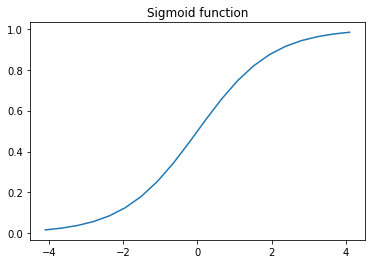

In [ ]:
plot_function(torch.nn.Sigmoid(), title='Sigmoid function')

Sigmoid function has no sharp edge, so gradients can be found anywhere. This will also ensure that predictions will be between 0 and 1. We typically use sigmoid function when we try to predict boolean values. For instance, we could use this function for problems like "is it a cat or dog?" 

Because we have multiple categories to predict, we use cross entropy loss. Cross entropy loss can be thought of as sigmoid designed for multiple categories. Cross entropy loss is composed of multiple functions. First, we use a softmax function ensures that all numbers are positive and add up to 1. Also, this function takes exponential of all values, so even the slight difference will be magnified. This will result in choosing one class with more confidence. Second, we take the log of the activations we got from softmax. Let's look at a log function.

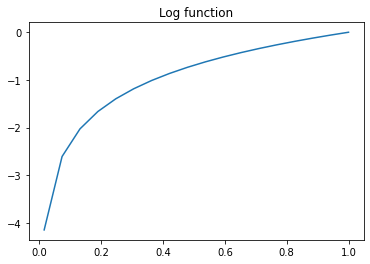

In [ ]:
plot_function(torch.log, title="Log function", xmin=-0.1, xmax=1)

In log function, we get a very big negative value if a number gets closer to 0, and reaches 0 when it gets 1. So, if our activation is close to 0 after softmax, it will be a big negative number after taking a log. This will result in a big gradient. However, if the number is close to 1, it is good enough. So, it will punish numbers that are far off, but forgiving for close numbers. But we still have problems. We still have 10 activation numbers and all of them are negative.

The last function we will use is negative log likelihood, which picks one number from our 10 activations and multiply by -1 to make it a positive value. Although it has log in its name, it actually does not take the log function. We have to do it ourselves. Let's take a look at how it looks like.

In [ ]:
sm_acts = torch.nn.Softmax(dim=1)(preds)
sm_acts[0]

tensor([4.6022e-09, 7.2222e-05, 3.6513e-02, 3.9309e-03, 2.0602e-11, 2.0636e-02,
        2.5585e-04, 9.9276e-09, 1.1795e-06, 9.3859e-01],
       grad_fn=<SelectBackward0>)

In [ ]:
log_acts = torch.log(sm_acts)
log_acts[0]

tensor([-19.1967,  -9.5358,  -3.3101,  -5.5389, -24.6057,  -3.8807,  -8.2709,
        -18.4279, -13.6504,  -0.0634], grad_fn=<SelectBackward0>)

In [ ]:
trn_y[0]

tensor(0)

In [ ]:
torch.nn.NLLLoss()(log_acts[0], trn_y[0])

tensor(19.1967, grad_fn=<NllLossBackward0>)

Notice that we get the same values for the built in cross entropy loss function.

In [ ]:
torch.nn.NLLLoss()(log_acts, trn_y)

tensor(14.3907, grad_fn=<NllLossBackward0>)

In [ ]:
loss = torch.nn.CrossEntropyLoss()(preds, trn_y)
loss

tensor(14.3907, grad_fn=<NllLossBackward0>)

It's easier to use the built in function, and it's also faster.

In [ ]:
%timeit torch.nn.CrossEntropyLoss()(preds, trn_y)

15.5 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit torch.nn.NLLLoss()(torch.log(torch.nn.Softmax(dim=1)(preds)), trn_y)

21.7 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Calculating gradients

So, we calculated the loss. With loss, we can calculate the gradients by calling `backward()`. Then, we can take a look at them.

In [ ]:
loss.backward()

In [ ]:
bias.grad, weights.grad.sum()

(tensor([-9.3132e-09]), tensor(-1.0490e-05))

We can define a function it.

In [ ]:
def calc_grad(xb, yb, model):
    "Calculate the gradients"
    preds = model(xb)
    loss = torch.nn.CrossEntropyLoss()(preds, yb)
    loss.backward()
    return loss

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(1)

In [ ]:
calc_grad(trn_x, trn_y, linear)
weights.grad.mean(), bias.grad.mean()

(tensor(-1.2164e-10), tensor(-9.3132e-09))

After calculating the gradients, we can update our parameters using the gradients. We can multiply parameter's gradient by any number, which is referred to as a learning rate. If it's big, it will train faster, and if it's slow, it will train slower. However, if it's too big, it cannot train. So, we can try couple numbers and see what works and what doensn't. After updating, we have to reset the gradients. If we don't, gradients will keep growing. 

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(1)
calc_grad(trn_x, trn_y, linear)
bias.grad, weights.grad.sum()

(tensor([-1.3039e-08]), tensor(-9.5367e-07))

In [ ]:
calc_grad(trn_x, trn_y, linear)
bias.grad, weights.grad.sum()

(tensor([-2.6077e-08]), tensor(-1.9073e-06))

See how it grew? we have to use `zero_()` on the gradients. Training _ on functions means in place function.

In [ ]:
weights.data -= weights.grad * 10
bias.data -= bias.grad * 10
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

## First training

If we put everything together, this is what it looks like. We will train with the whole data 20 times, which means we are using 20 epochs.

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(1)
for _ in range(20):
    calc_grad(trn_x, trn_y, linear)
    weights.data -= weights.grad * 10
    weights.grad.zero_()
    bias.data -= bias.grad * 10
    bias.grad.zero_()
    pred = linear(tst_x)
    print(acc(pred, tst_y))

tensor(20.9500)
tensor(38.9100)
tensor(40.2700)
tensor(48.3800)
tensor(42.6600)
tensor(51.5200)
tensor(45.4200)
tensor(57.6000)
tensor(60.3500)
tensor(62.2100)
tensor(67.2600)
tensor(70.8800)
tensor(75.0300)
tensor(71.8100)
tensor(76.1800)
tensor(82.2500)
tensor(85.1200)
tensor(85.3800)
tensor(85.1700)
tensor(85.1200)


We got over 80% accuracy, which is better tan our baseline using means of images from the last time, which had 66% accuracy. However, we can still make this better. 

## Minibatches

We updated our parameters after looking at the whole dataset. The MNIST dataset is very small, so it's not a problem, but dataset can get really big, and it would take a long time to train this way. Another approach to train is update parameters after each image. This is not a good idea either as our model learns about one image at a time, which can lead to overfitting. That's why we use small batches of data. 

In [ ]:
dl = DataLoader(trn_dset, bs=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256]))

With fastai's DataLoader, we will have 256 items per batch. And we will do the same thing for the test set.

In [ ]:
tst_dl = DataLoader(tst_dset, bs=256)

In [ ]:
def train(lr=1.):
    params = weights, bias
    for xb, yb in dl:
        calc_grad(xb, yb, linear)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [ ]:
def validate_epoch(model):
    accs = [acc(model(xb), yb) for xb, yb in tst_dl]
    return round(tensor(accs).mean().item(), 4)

In [ ]:
weights = init_params((28*28, 10))
bias = init_params(1)
for _ in range(30):
    train(0.1)
    print(validate_epoch(linear), end='; ')

15.9961; 27.8516; 39.1016; 46.3672; 51.3281; 54.8535; 57.2656; 59.4922; 61.1328; 62.5098; 63.6328; 64.5605; 65.2637; 65.9766; 66.6699; 67.2754; 67.9004; 68.418; 68.9355; 69.3164; 69.6777; 70.0586; 70.3809; 70.625; 70.8789; 71.1328; 71.3379; 71.5039; 71.6602; 71.8262; 

Accuracy is not as good as using the whole dataset, but let's keep trying more things.

## Optimizer

We can use pytorch's `torch.nn.Linear` instead of our `linear`. Good thing about using this is that we can get grab parameters easily.

In [ ]:
linear_model = torch.nn.Linear(28*28, 10)

In [ ]:
w, b = list(linear_model.parameters())
w.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

We define a `BasicOptim` class that has `step` and `zero_grad` methods.

In [ ]:
class BasicOptim:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr
    
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

Optimizer can be used this way. And we can update our train function to use the optimizer.

In [ ]:
opt = BasicOptim(list(linear_model.parameters()))

In [ ]:
def train(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

It's good to define a function to train a model.

In [ ]:
def train_model(epochs, model):
    for _ in range(epochs):
        train(model)
        print(validate_epoch(model))

In [ ]:
train_model(20, linear_model)

12.2266
31.3184
46.7578
55.4785
61.2988
65.1953
68.4375
70.9473
72.9297
74.8047
76.25
77.5391
78.6035
79.6094
80.3027
80.9473
81.6016
82.2754
82.8027
83.2031


We can also use fastai's SGD.

In [ ]:
linear_model = nn.Linear(28*28, 10)
opt = SGD(list(linear_model.parameters()), .01)

In [ ]:
train_model(20, linear_model)

12.2461
32.4121
47.0117
55.4004
61.1621
65.166
68.418
70.8398
72.9297
75.1172
76.377
77.5488
78.623
79.4922
80.3809
81.0547
81.582
82.2363
82.7148
83.0664


Also, we can use fastai's learner. We just need `DataLoaders`, which combines training dataloaders with test dataloaders. By using `learn.fit`, we can train easily and get a nice output, too.

In [ ]:
dls = DataLoaders(dl, tst_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28, 10), loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=acc)

In [ ]:
learn.fit(20, 0.01)

epoch,train_loss,valid_loss,acc,time
0,1.030682,2.442845,10.260000,00:03
1,0.756178,1.755957,30.840000,00:04
2,0.652057,1.387471,45.750000,00:04
3,0.593682,1.172395,54.570000,00:03
4,0.555542,1.030824,60.259998,00:06
5,0.528407,0.930011,64.510002,00:05
6,0.507978,0.854310,67.820000,00:06
7,0.491943,0.795262,70.309998,00:03
8,0.478946,0.747864,72.440002,00:05
9,0.468138,0.708950,74.440002,00:03


We can improve this accuracy with adding another linear layers and a relu layer. We create a deeper network as long as there's a relu layer in between each linear layer. Relu layer simply turns negative numbers to 0.

In [ ]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

We made a network of layers. Since it is deeper, we have to reduce the learning rate, which results in slower training speed. However, we can train for more epochs. Let's try training for 100 epochs.

In [ ]:
learn = Learner(dls, net, loss_func=nn.CrossEntropyLoss(), 
                opt_func=SGD, metrics=acc)
learn.fit(100, 0.004)

epoch,train_loss,valid_loss,acc,time
0,2.257359,2.186582,28.950001,00:04
1,1.927473,2.062460,16.990000,00:05
2,1.586289,1.925866,19.389999,00:07
3,1.296686,1.757989,29.430000,00:04
4,1.077161,1.585793,37.320000,00:06
5,0.920138,1.439800,42.250000,00:07
6,0.809401,1.322030,45.910000,00:08
7,0.729531,1.226982,48.950001,00:04
8,0.669996,1.148582,52.099998,00:06
9,0.624211,1.082637,54.900002,00:05


After 100 epochs, we reached over 87% accuracy!

So, we completed the project. That was very fun. Thanks for reading.